In [26]:
import datetime
import collections
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing



In [2]:
stop_words = stopwords.words('english')
stemmer = nltk.SnowballStemmer("english")

In [3]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [4]:
def read_train():
    train = pd.read_csv('../input/tweet-sentiment-exam/train.csv').dropna()
    train['text'] = train['text']
    train['selected_text'] = train['selected_text']
    return train

def read_test():
    test = pd.read_csv('../input/tweet-sentiment-exam/test.csv').dropna()
    test['text'] = test['text']
    return test

def clean_text(text):
    text = str(text).lower()
    pat = r"[{}]".format(string.punctuation)
    text = re.sub(pat, ' ', text)
    text = re.sub('  +', ' ', text)
    text = re.sub('https?://|www\.', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def preprocess_data(text):
    text = text if clean_text(text)==0 else clean_text(text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # text = ' '.join(stemmer.stem(word) for word in text.split())
    return text

def wrong_words(text, selected):
    words = []
    text = text.split()
    selected = selected.split()
    for i in selected:
        if i not in text:
            words.append(i)
    if len(words) > 0:
        return " ".join(words)
    else:
        return '++++'

def remove_text(x):
    selected = x[0]
    spelling = x[1]
    selected = selected.split()
    selected.remove(spelling)
    return " ".join(selected)

def remove_text_end(x):
    selected = x[0]
    spelling = x[1]
    selected = selected.split()
    if selected[-1] == spelling:
        selected.remove(spelling)
    return " ".join(selected)

def matching(x, tg):
    text = x[0]
    selected = x[1]
    spelling = x[2]
    text = text.split()
    selected = selected.split()
    spelling = spelling.split()
    for s in spelling:
        for t in text:
            if s in selected:
                if(fuzz.ratio(t, s) > tg):
                    index = selected.index(s)
                    selected[index] = t
    return " ".join(selected)

def start_index(x):
    text = x[0]
    selected = x[1]
    text = text.split()
    selected = selected.split()
    try:
        word = selected[0]
        index = text.index(word)
    except:
        index = 0
    return index

def end_index(x):
    text = x[0]
    selected = x[1]
    start_index = x[2]
    text = text.split()
    selected = selected.split()
    word = selected[-1]
    try:
        index = text.index(word, start_index)
    except:
        try:
            index = text.index(word)
        except:
            index = len(text) - 1
    return index

def get_text(x):
    pred = []
    text = x[0]
    index = x[1]
    text = text.split()
    l = len(text)
    for i in index:
        if i < l:
            pred.append(text[i])
    return pred

In [102]:
train = read_train()
train = train[:1000]  # TODO
train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,2
2,088c60f138,my boss is bullying me...,bullying me,2
3,9642c003ef,what interview! leave me alone,leave me alone,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",2
...,...,...,...,...
995,fe6301dd3a,my sleep pattern is screwed i need to try and...,my sleep pattern is screwed,1
996,fd98097a71,Since the demise of Woolworths it isn`t easy ...,isn`t easy to find,2
997,a7b4ba7093,may the fourth be with you! happy star wars day,may the fourth be with you! happy star wars day,1
998,6d2170e60f,I`ve been unlocked for decades now...just not...,".just not lucky, never have been.",2


In [103]:
test = read_test()
test

,textID,text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!
...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ..."
3530,416863ce47,All alone in this old house again. Thanks for...
3531,6332da480c,I know what you mean. My little dog is sinkin...
3532,df1baec676,_sutra what is your next youtube video gonna b...


In [104]:
train['clean_text'] = train['text'].apply(preprocess_data)
test['clean_text'] = test['text'].apply(preprocess_data)

In [105]:
train

,textID,text,selected_text,sentiment,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",0,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,2,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,2,boss bullying
3,9642c003ef,what interview! leave me alone,leave me alone,2,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",2,sons put releases already bought
...,...,...,...,...,...
995,fe6301dd3a,my sleep pattern is screwed i need to try and...,my sleep pattern is screwed,1,sleep pattern screwed need try stay midnight g...
996,fd98097a71,Since the demise of Woolworths it isn`t easy ...,isn`t easy to find,2,since demise woolworths easy find reasonably p...
997,a7b4ba7093,may the fourth be with you! happy star wars day,may the fourth be with you! happy star wars day,1,may fourth happy star wars day
998,6d2170e60f,I`ve been unlocked for decades now...just not...,".just not lucky, never have been.",2,unlocked decades lucky never gottta make luck ...


In [106]:
test

,textID,text,clean_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,last session day http twitpic com
1,96d74cb729,Shanghai is also really exciting (precisely -...,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,http twitpic com like
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",im tired sleep try
3530,416863ce47,All alone in this old house again. Thanks for...,alone old house thanks net keeps alive kicking...
3531,6332da480c,I know what you mean. My little dog is sinkin...,know mean little dog sinking depression wants ...
3532,df1baec676,_sutra what is your next youtube video gonna b...,sutra next youtube video gonna love videos


In [107]:
y = tf.keras.utils.to_categorical(train['sentiment'])
y

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [108]:
y.shape

(1000, 3)

In [109]:
X = train[['clean_text', 'sentiment']]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape ", X_train.shape, "  X_test shape ", X_valid.shape)
print("y_train shape ", y_train.shape, "  y_test shape ", y_valid.shape)

X_train shape  (800, 2)   X_test shape  (200, 2)
y_train shape  (800, 3)   y_test shape  (200, 3)


In [111]:
train_text = X_train['clean_text'].values
valid_text = X_valid['clean_text'].values

train_text[:5], valid_text[:5]

(array(['went sleep power cut noida power back working',
        'barbs trying figure dsl aint connecting need google going home computer start working soon smh',
        'invite house instead',
        'feeling loved mom got nikon cool pix birthday',
        'third date went well moving fourth'], dtype=object),
 array(['garden going well almost corn peas onions beets yet though',
        'anyone want buy anthropomorphic planter http tinyurl com available till',
        'creative vado stock walmart com missed thanks tweeting',
        'hi mariah',
        'x atl u mean jack barakat wow u ever gone house hehe mean ur ssoo lucky address'],
       dtype=object))

In [64]:
token = text.Tokenizer(num_words=None)
max_len_text = 90

token.fit_on_texts(list(train_text))
train_text = token.texts_to_sequences(train_text)
valid_text = token.texts_to_sequences(valid_text)

train_text = sequence.pad_sequences(train_text, maxlen=max_len_text, padding='post')
valid_text = sequence.pad_sequences(valid_text, maxlen=max_len_text, padding='post')

word_index_text = token.word_index
print(train_text.shape, valid_text.shape)

(21984, 30) (5496, 30)


In [94]:
text_input = tf.keras.layers.Input(shape=(max_len_text,), name='text_input')
embd_text = tf.keras.layers.Embedding(len(word_index_text)+1,
                                      300,
                                      input_length=max_len_text,
                                      trainable=True,
                                      mask_zero=True,
                                      name='embedding_text')(text_input)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.15, name='LSTM'))(embd_text)
x = tf.keras.layers.LSTM(128, dropout=0.15, name='LSTM')(embd_text)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(3, activation='softmax', name='output')(x)

model = tf.keras.Model(inputs=[text_input], outputs=[output])

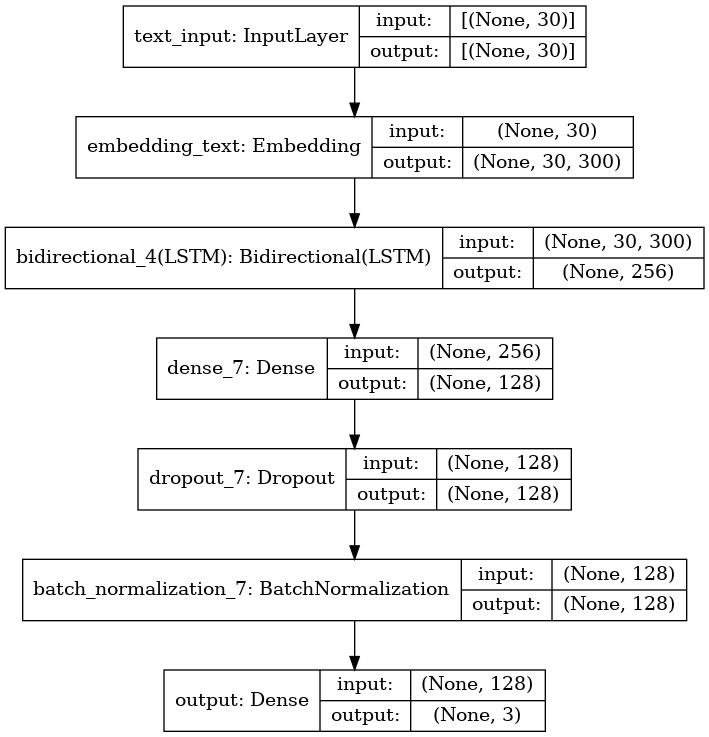

In [95]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [96]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 30)]              0         
_________________________________________________________________
embedding_text (Embedding)   (None, 30, 300)           6276000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 3)                 387 

In [97]:
model_filenm = 'model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_filenm, monitor='val_loss', save_best_only=True, verbose=1)
adam = tf.keras.optimizers.Adam()

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
callback = [checkpoint]

history = model.fit(train_text,
                    y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(valid_text, y_valid),
                    verbose=1,
                    callbacks=callback)

Epoch 1/10
 23/344 [=>............................] - ETA: 21s - loss: 1.0424 - accuracy: 0.4511

KeyboardInterrupt: 

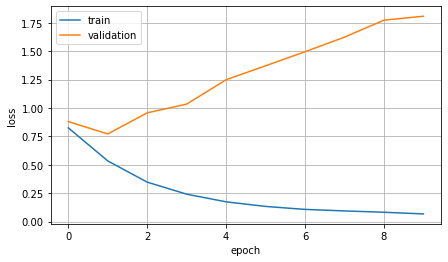

In [69]:
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

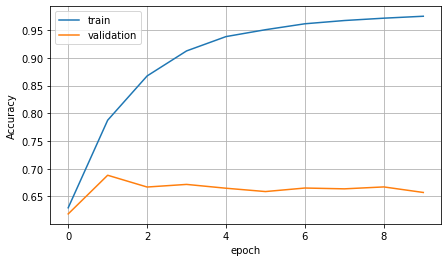

In [70]:
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

# Infer Model

In [85]:
model = tf.keras.models.load_model('model.h5')
test_text = test['clean_text'].values
test_text = token.texts_to_sequences(test_text)
test_text = sequence.pad_sequences(test_text, maxlen=max_len_text, padding='post')

test_pred = model.predict(test_text)
test_pred = np.argmax(test_pred, axis=1)
test_pred.shape, test_pred

((3534,), array([0, 1, 2, ..., 2, 1, 0]))

In [88]:
submission = pd.read_csv('../input/tweet-sentiment-exam/sample_submission.csv')

In [90]:
submission['sentiment'] = test_pred
submission.to_csv('submission.csv', index=False)
submission

,textID,sentiment
0,f87dea47db,0
1,96d74cb729,1
2,eee518ae67,2
3,01082688c6,1
4,33987a8ee5,0
...,...,...
3529,e5f0e6ef4b,2
3530,416863ce47,0
3531,6332da480c,2
3532,df1baec676,1


# End of Program